<a href="https://colab.research.google.com/github/achmadbauravindah/ImageSegmentation-UNet-XRayLungImages/blob/main/ImageSegmentation_UNet_XRayLungImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPool2D, Concatenate, Dropout, Lambda, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, array_to_img, img_to_array

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

In [2]:
# Get data from Kaggle
_ = ! git clone https://github.com/achmadbauravindah/ravin_kaggle_credential.git # get credential from kaggle
_ = ! pip install kaggle # install kaggle on device
_ = ! mkdir ~/.kaggle # make hidden folder .kaggle to configure credential
_ = ! cp ravin_kaggle_credential/kaggle.json ~/.kaggle/ # copy credential from github to .kaggle folder
_ = ! chmod 600 ~/.kaggle/kaggle.json # change access
_ = ! kaggle datasets download x-ray-scan-lung-images # which dataset to download
_ = ! unzip x-ray-scan-lung-images # unzip if data zipped

### Global Variable

In [3]:
# SET UP GLOBAL VARIABLE
DEFAULT_IMG_WIDTH = 512
DEFAULT_IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
DATA_PATH = 'dataset_x_ray_scan_lung_images'

## Preprocessing data

In [4]:
sample_image_path = os.path.join(DATA_PATH, 'train', 'image', 'cxrimage_0.png')
image_default_pixel = img_to_array(load_img(sample_image_path))
image_default_pixel.shape

(512, 512, 3)

In [5]:
def getArrImages(path, total = 100):
  # saved array
  images_arr = []
  masks_arr = []

  # Set Path image and mask
  images_path = os.path.join(path, 'image')
  masks_path = os.path.join(path, 'mask')

  # total_images in directory
  # images_total = len(os.listdir(images_path))
  # masks_total = len(os.listdir(masks_path))
  # total = images_total # images and masks have same total
  
  # Get array from images and masks
  for idx in tqdm(range(total)):
    # IMAGES
    image_path = images_path + '/cxrimage_' + str(idx) +'.png'
    image = load_img(image_path, color_mode='rgb', target_size=(IMG_HEIGHT, IMG_WIDTH))
    image_arr = img_to_array(image).astype('float32') / 255.0
    images_arr.append(image_arr)
    # MASKS
    mask_path = masks_path + '/cxrmask_' + str(idx) +'.jpeg'
    mask = load_img(mask_path, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    mask_arr = img_to_array(mask).astype('float32') / 255.0
    masks_arr.append(mask_arr)

  return np.array(images_arr), np.array(masks_arr)


In [6]:
# Create Path
path_train = os.path.join(os.getcwd(), DATA_PATH, 'train')
path_val = os.path.join(os.getcwd(), DATA_PATH, 'val')
path_test = os.path.join(os.getcwd(), DATA_PATH, 'test')

In [7]:
# Call getArrImages to Get Array All Images and Data
train_images, train_masks = getArrImages(path_train, 200)
val_images, val_masks = getArrImages(path_val, 20)
test_images, test_masks = getArrImages(path_test, 20)

100%|██████████| 20/20 [00:00<00:00, 49.59it/s]


In [8]:
# Shape All Data
print("Shape of Training Data - Images: {}, Masks: {}".format(train_images.shape, train_masks.shape))
print("Shape of Validation Data - Images: {}, Masks: {}".format(val_images.shape, val_masks.shape))
print("Shape of Testing Data - Images: {}, Masks: {}".format(test_images.shape, test_masks.shape))

Shape of Training Data - Images: (200, 512, 512, 3), Masks: (200, 512, 512, 1)
Shape of Validation Data - Images: (20, 512, 512, 3), Masks: (20, 512, 512, 1)
Shape of Testing Data - Images: (20, 512, 512, 3), Masks: (20, 512, 512, 1)


### Model UNet Building for Segmentation


In [9]:
# UNet Model
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

# Construction
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPool2D((2,2))(c1)

c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1) 
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPool2D((2,2))(c2)

c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPool2D((2,2))(c3)

c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPool2D((2,2))(c4)


c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)


# Expansive
u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2,)(c6)
c6 = Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2,)(c7)
c7 = Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1,)(c8)
c8 = Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1,)(c9)
c9 = Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [12]:
# Model Training
history = model.fit(train_images, 
                    train_masks, 
                    validation_data=(val_images, val_masks), 
                    batch_size=32,
                    epochs=100)

Epoch 1/100
7/7 [==============================] - 8s 1s/step - loss: 0.4460 - accuracy: 0.7350 - val_loss: 0.4391 - val_accuracy: 0.7241
Epoch 2/100
7/7 [==============================] - 8s 1s/step - loss: 0.5097 - accuracy: 0.7350 - val_loss: 0.4766 - val_accuracy: 0.7236
Epoch 3/100
7/7 [==============================] - 8s 1s/step - loss: 0.4689 - accuracy: 0.7351 - val_loss: 0.4203 - val_accuracy: 0.7262
Epoch 4/100
7/7 [==============================] - 8s 1s/step - loss: 0.4414 - accuracy: 0.7361 - val_loss: 0.4274 - val_accuracy: 0.7485
Epoch 5/100
7/7 [==============================] - 8s 1s/step - loss: 0.4159 - accuracy: 0.7395 - val_loss: 0.3988 - val_accuracy: 0.7558
Epoch 6/100
7/7 [==============================] - 8s 1s/step - loss: 0.3944 - accuracy: 0.7496 - val_loss: 0.3751 - val_accuracy: 0.7972
Epoch 7/100
7/7 [==============================] - 8s 1s/step - loss: 0.3726 - accuracy: 0.7818 - val_loss: 0.3584 - val_accuracy: 0.8454
Epoch 8/100
7/7 [=================

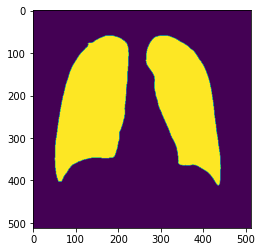

In [13]:
pred = model.predict(test_images)

pred = (pred > 0.5).astype(np.uint8)
plt.imshow(np.squeeze(pred[0]))

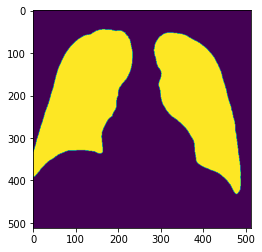

In [18]:
plt.imshow(np.squeeze(pred[7]))